In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from himodule.custom_classes import NasaDataset, SimpleAE, split_dataset, seed_everything, split_anomaly_normal, AnomalyDataset, AnomalyLoader
from himodule.ae_metrics import MAPE
from himodule.rul_metrics import RMSELoss
from himodule.normalisation import StandardScaler, MinMaxScaler

from collections import defaultdict

import os

sns.set_theme(style='whitegrid', font_scale=1.2)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [3]:
class LossAndMetric(nn.Module):
    def __init__(self, loss_func: object, metric_func: object, scaler: object = None):
        super(LossAndMetric, self).__init__()
        self.loss_func = loss_func
        self.metric_func = metric_func
        self.scaler = scaler
    
    
    def forward(self, predicted_values: torch.Tensor, true_values: torch.Tensor) -> tuple:
        loss = self.loss_func(predicted_values, true_values)

        if self.scaler:
            metric = self.metric_func(self.scaler.inverse_transform(predicted_values),
                                 self.scaler.inverse_transform(true_values))
        else:
            metric = self.metric_func(predicted_values, true_values)
        
        return loss, metric

In [4]:
seed = 37

train_dataset = NasaDataset('../datasets/clean_train_data.csv')
train_dataset, anomaly_dataset = split_anomaly_normal(train_dataset)
seed_everything(seed)
train_dataset, val_dataset = split_dataset(train_dataset, test_size=0.3)

test_dataset = NasaDataset('../datasets/clean_test_data.csv')

scaler = MinMaxScaler()
try:
    norm_name = repr(scaler).split(' ', maxsplit=2)[0].split('.')[-1]
except IndexError:
    norm_name = 'no_scaling'
for idx, dtset in enumerate((train_dataset, val_dataset, test_dataset, anomaly_dataset)):
    dtset.to(device)
    if scaler:
        if idx == 0:
            scaler.fit(dtset.dataset)
        dtset.dataset = scaler.transform(dtset.dataset)

seed_everything(seed)
g = torch.Generator()
g.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
val_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)

seed_everything(seed)
test_loader = DataLoader(val_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)

seed_everything(seed)
anomaly_loader = AnomalyLoader(anomaly_dataset, batch_size=20)

print(f'Train: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}')
print(f'Anomaly: {len(anomaly_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (8, 4, 2)

seed_everything(seed)
model_ae = SimpleAE(input_shape, layers_sizes).to(device)
loss_func = nn.MSELoss()
metric_func = MAPE()
get_loss_and_metric = LossAndMetric(loss_func, metric_func, scaler)
get_loss_and_metric_anomaly = LossAndMetric(nn.MSELoss(reduction='none'), metric_func, scaler)
optimiser = optim.AdamW(model_ae.parameters(),
                       lr=1e-3)
optimiser_name = repr(optimiser).split(' ', maxsplit=1)[0]

Train: 5960
Validation: 2171
Test: 13096
Anomaly: 12500


In [5]:
def plot_history(history_df: pd.DataFrame, ylabel: str = None, save_path: str = None):
    history_df = history_df.melt(ignore_index=False).iloc[1:]
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    sns.lineplot(data=history_df,
                x=history_df.index,
                y='value',
                hue='variable')

    ax.set_ylabel(ylabel)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [6]:
def check_path(pth):
    if not os.path.exists(pth):
        os.makedirs(pth)
    return pth

def evaluate_model(model: nn.Module, loader: DataLoader, ):
    with torch.no_grad():
        losses = list()
        metrics = list()
        for dta in loader:
            sample = dta['sensors']
            sample = sample.to(device)
            _, reconstruction = model(sample)

            loss, metric = get_loss_and_metric(reconstruction, sample)

            losses.append(loss.item())
            metrics.append(metric.item())
    return losses, metrics

In [7]:
epochs = 100
history = list()

for epoch in range(epochs):
    train_losses = list()
    train_metrics = list()
    for dta in train_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)

        loss, metric = get_loss_and_metric(reconstruction, sample)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
        train_metrics.append(metric.item())
    
    val_losses, val_metrics = evaluate_model(model_ae, val_loader)
    
    train_loss, val_loss = mean(train_losses), mean(val_losses)
    train_metrics, val_metrics = mean(train_metrics), mean(val_metrics)
    history.append((epoch, train_loss, val_loss, train_metrics, val_metrics))
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'{epoch+1:>3}/{epochs:>3}: {train_loss=:.4f}, {val_loss=:.4f}, {train_metrics=:.4f}%, {val_metrics=:.4f}%')

test_losses, test_metrics = evaluate_model(model_ae, test_loader)
test_loss = mean(test_losses)
test_metric = mean(test_metrics)
print(f'\n{test_loss=:.4f}, {test_metric=:.4f}%')


with torch.no_grad():
    anomaly_losses = defaultdict(list)
    anomaly_metrics = list()
    for dta in anomaly_loader:
        sample = dta['sensors']
        machine_id = dta['machine_id'][0].item()
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        
        loss, metric = get_loss_and_metric_anomaly(reconstruction, sample)
        anomaly_losses[int(machine_id)].append(loss.mean(dim=1))
        anomaly_metrics.append(metric)
    
    for key, values in anomaly_losses.items():
        anomaly_losses[key] = torch.hstack(values)
#     anomaly_loss = mean(anomaly_losses)
#     anomaly_metric = mean(anomaly_metrics)
#     print(f'\n{anomaly_loss=:.4f}, {anomaly_metric=:.4f}%')

 10/100: train_loss=0.0201, val_loss=0.0189, train_metrics=13.2521%, val_metrics=14.1512%
 20/100: train_loss=0.0130, val_loss=0.0129, train_metrics=13.3884%, val_metrics=13.3040%
 30/100: train_loss=0.0123, val_loss=0.0123, train_metrics=12.2718%, val_metrics=12.9837%
 40/100: train_loss=0.0120, val_loss=0.0119, train_metrics=11.4700%, val_metrics=11.2890%
 50/100: train_loss=0.0119, val_loss=0.0119, train_metrics=10.9706%, val_metrics=11.1994%
 60/100: train_loss=0.0118, val_loss=0.0118, train_metrics=10.6491%, val_metrics=11.1105%
 70/100: train_loss=0.0118, val_loss=0.0118, train_metrics=10.3788%, val_metrics=10.3918%
 80/100: train_loss=0.0118, val_loss=0.0118, train_metrics=10.2069%, val_metrics=10.3676%
 90/100: train_loss=0.0118, val_loss=0.0118, train_metrics=10.0955%, val_metrics=10.3571%
100/100: train_loss=0.0118, val_loss=0.0118, train_metrics=9.9807%, val_metrics=9.7329%

test_loss=0.0114, test_metric=10.7421%


In [18]:
def transform_train_history(history: list) -> pd.DataFrame:
    columns = ('epoch', 'train_loss', 'val_loss', 'train_metric', 'val_metric')
    total_history_df = pd.DataFrame(history, columns=columns).set_index('epoch')

    history_df = total_history_df.loc[:,('train_loss', 'val_loss')].iloc[2:].melt(ignore_index=False)
    return history_df


def transform_anomaly_history(history: dict):
    counter = 0
    dfs = list()
    for machine_id, losses in history.items():
        if counter == 3:
            yield pd.concat(dfs, axis=1, ignore_index=False).melt(ignore_index=False)
            counter = 0
            dfs = list()
        
        dfs.append(pd.Series(losses.cpu(), name=machine_id))
        counter += 1


def plot_lines(ax: plt.Axes, history_df: pd.DataFrame, anomaly_df: dict, title: str = None):
    sns.lineplot(data=history_df,
                x=history_df.index,
                y='value',
                hue='variable',
                ax=ax)

    sns.lineplot(data=anomaly_df,
                x=anomaly_df.index,
                y='value',
                hue='variable',
                ax=ax)
    
    ax.legend()
    ax.set_title(title)

    ax.set_ylabel('MSE')

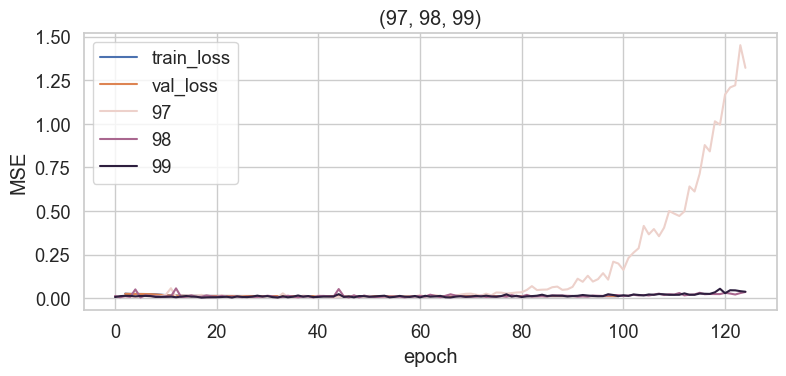

In [17]:
history_df = transform_train_history(history)

for anomaly_df in transform_anomaly_history(anomaly_losses):
    plt.close()
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)
    title = tuple(anomaly_df['variable'].unique())
    plot_lines(ax, history_df, anomaly_df, title=title)

    plt.tight_layout()
    plt.savefig(f'../Plots/history/norm-anom/{title}.png')